# Part 0 :Data

### Downloading Data

In [1]:
!cd data && wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt 

File ‘spa.txt’ already there; not retrieving.



### Data Preparation

In [2]:
import pandas as pd
df = pd.read_csv('data/spa.txt', sep="\t", header=None)
df.columns = ['en', 'es']
df = df.iloc[:10_000] # takes too long (smaller sample)
df.to_csv('data/spa.csv', index=None)
df.head()


,en,es
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Hi.,Hola.
4,Run!,¡Corre!


In [3]:
!pip install transformers datasets sentencepiece sacremoses


Defaulting to user installation because normal site-packages is not writeable


In [4]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data/spa.csv')
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

from transformers import AutoTokenizer
model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
### looking at sample tokenizer
en_sentence = split["train"][0]["en"]
es_sentence = split["train"][0]["es"]

inputs = tokenizer(en_sentence)
targets = tokenizer(text_target=es_sentence)

print(f"{es_sentence=}")
tokenizer.convert_ids_to_tokens(targets['input_ids'])


es_sentence='Tom dejó entrar a Mary.'


['▁Tom', '▁dejó', '▁entrar', '▁a', '▁Mary', '.', '</s>']

In [6]:
max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
    model_inputs = tokenizer(
        batch['en'], max_length=max_input_length, truncation=True)

    # Set up the tokenizer for targets
    labels = tokenizer(
        text_target=batch['es'], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [7]:
tokenized_datasets = split.map(
    preprocess_function,
    batched=True,
    remove_columns=split["train"].column_names,
)
tokenized_datasets



Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
})

In [8]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer)
batch = data_collator([tokenized_datasets["train"][i] for i in range(0, 5)])
batch.keys()
print(f"{batch['input_ids']=}")
print(f"{batch['attention_mask']=}")
print(f"{batch['labels']=}")


batch['input_ids']=tensor([[ 5266,   965,  4963,    16,     3,     0],
        [ 9680,   282,     3,     0, 65000, 65000],
        [  124,   864,   167,     3,     0, 65000],
        [ 1086,  1030,    55,     0, 65000, 65000],
        [   33,   675,  2778,     3,     0, 65000]])
batch['attention_mask']=tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0]])
batch['labels']=tensor([[ 5266,  7464,  3531,     8,  4963,     3,     0],
        [ 1259, 31575, 18368,  2266,     3,     0,  -100],
        [  131, 43360,     3,     0,  -100,  -100,  -100],
        [  107, 47657,    55,     0,  -100,  -100,  -100],
        [ 1686,  7474,     3,     0,  -100,  -100,  -100]])


In [9]:
print(f"{tokenizer.all_special_ids=}")
print(f"{tokenizer.all_special_tokens=}")
tokenizer.add_special_tokens({"cls_token": "<s>"})


tokenizer.all_special_ids=[0, 1, 65000]
tokenizer.all_special_tokens=['</s>', '<unk>', '<pad>']


1

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=128,
    collate_fn=data_collator
)
valid_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=128,
    collate_fn=data_collator
)


# Model
### Loading and training base model

In [11]:
from models.Transformer import Transformer,Encoder,Decoder
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt


In [12]:
encoder = Encoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
transformer = Transformer(encoder, decoder)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cuda:0


Decoder(
  (embedding): Embedding(65002, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
 

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters())


In [15]:
from datetime import datetime
import time

# A function to encapsulate the training loop
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
    
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  time_dataloading = np.zeros(epochs)
  time_training = np.zeros(epochs)
  time_epoch = np.zeros(epochs)
  train_accuracy = np.zeros(epochs)
  test_accuracy = np.zeros(epochs)
    
    
    
  for it in range(epochs):
    model.train()
    train_loss = []
    dataloading_time = 0
    epoch_time = 0
    training_time = 0
      
    torch.cuda.synchronize()
    epoch_time_start = time.perf_counter() # epoch start
    torch.cuda.synchronize()
    dataloading_time_start = time.perf_counter() # dataloading
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        torch.cuda.synchronize()
        dataloading_time_end = time.perf_counter() # dataloading
        
        # move data to GPU (enc_input, enc_mask, translation)
        batch = {k: v.to(device) for k, v in batch.items()}

        torch.cuda.synchronize()
        batch_time_start = time.perf_counter() # batch training start

      # zero the parameter gradients
        optimizer.zero_grad()

        enc_input = batch['input_ids']
        enc_mask = batch['attention_mask']
        targets = batch['labels']

      # shift targets forwards to get decoder_input
        dec_input = targets.clone().detach()
        dec_input = torch.roll(dec_input, shifts=1, dims=1)
        dec_input[:, 0] = 65_001

      # also convert all -100 to pad token id
        dec_input = dec_input.masked_fill(
            dec_input == -100, tokenizer.pad_token_id)

      # make decoder input mask
        dec_mask = torch.ones_like(dec_input)
        dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

      # Forward pass
        outputs = model(enc_input, dec_input, enc_mask, dec_mask)
        loss = criterion(outputs.transpose(2, 1), targets)
        
      # Backward and optimize
        loss.backward()
        optimizer.step()
        torch.cuda.synchronize()
        
        batch_time_end = time.perf_counter() # batch training end
        training_time += (batch_time_end-batch_time_start)

        train_loss.append(loss.item())
        
        # Compute accuracy
        predictions = torch.argmax(outputs, dim=2)  # Shape: (batch_size, seq_len)
        mask = targets != -100  # Ignore padded tokens in accuracy calculation
        train_correct += (predictions[mask] == targets[mask]).sum().item()
        train_total += mask.sum().item()

        dataloading_time += (dataloading_time_end-dataloading_time_start)
        torch.cuda.synchronize()
        dataloading_time_start = time.perf_counter() # dataloading

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    test_correct = 0
    test_total = 0

    for batch in valid_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        enc_input = batch['input_ids']
        enc_mask = batch['attention_mask']
        targets = batch['labels']

      # shift targets forwards to get decoder_input
        dec_input = targets.clone().detach()
        dec_input = torch.roll(dec_input, shifts=1, dims=1)
        dec_input[:, 0] = 65_001

      # change -100s to regular padding
        dec_input = dec_input.masked_fill(
            dec_input == -100, tokenizer.pad_token_id)

      # make decoder input mask
        dec_mask = torch.ones_like(dec_input)
        dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

        outputs = model(enc_input, dec_input, enc_mask, dec_mask)
        loss = criterion(outputs.transpose(2, 1), targets)
        test_loss.append(loss.item())

      # Compute accuracy
        predictions = torch.argmax(outputs, dim=2)  # Shape: (batch_size, seq_len)
        mask = targets != -100  # Ignore padded tokens in accuracy calculation
        test_correct += (predictions[mask] == targets[mask]).sum().item()
        test_total += mask.sum().item()

    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    torch.cuda.synchronize()
    epoch_time_end = time.perf_counter() # epoch end
    epoch_time += (epoch_time_end-epoch_time_start)
    time_epoch[it] = epoch_time
    time_dataloading[it]= dataloading_time
    time_training[it]= training_time
    train_accuracy[it]= train_correct/train_total
    test_accuracy[it]=test_correct/test_total

    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Training Accuracy: {train_correct/train_total:.4f}\
      Test Loss: {test_loss:.4f}, Test Accuracy: {test_correct/test_total:.4f}, Epoch Time: {epoch_time:.4f}, Dataloading Time: {dataloading_time:.4f}, Training Time: {training_time:.4f}')

  return train_losses, test_losses,time_epoch,time_dataloading,time_training,train_accuracy,test_accuracy


In [16]:
train_losses, test_losses,time_epoch,time_dataloading,time_training,train_accuracy,test_accuracy = train(
    transformer, criterion, optimizer, train_loader, valid_loader, epochs=1)


Epoch 1/1, Train Loss: 8.0534, Training Accuracy: 0.2984      Test Loss: 5.5909, Test Accuracy: 0.3461, Epoch Time: 3.7507, Dataloading Time: 0.1980, Training Time: 2.8425


### Optimize Dataloading

#### num_of_worker

In [17]:
number_workers= [1,2,4,8,16]
trainloading = []

for nw in number_workers:
    print(f"\n{nw =}")
    train_loader = DataLoader(
        tokenized_datasets["train"],
        shuffle=True,
        batch_size=128,
        collate_fn=data_collator,
        num_workers = nw
    )

    train_losses, test_losses,time_epoch,time_dataloading,time_training,train_accuracy,test_accuracy = train(
        transformer, criterion, optimizer, train_loader, valid_loader, epochs=5)

    trainloading.append(np.mean(time_dataloading))
    


nw =1
Epoch 1/5, Train Loss: 4.9862, Training Accuracy: 0.3636      Test Loss: 4.7039, Test Accuracy: 0.3991, Epoch Time: 3.2357, Dataloading Time: 0.2048, Training Time: 2.3607
Epoch 2/5, Train Loss: 4.3710, Training Accuracy: 0.4123      Test Loss: 4.3497, Test Accuracy: 0.4333, Epoch Time: 3.1923, Dataloading Time: 0.2094, Training Time: 2.2616
Epoch 3/5, Train Loss: 4.0449, Training Accuracy: 0.4383      Test Loss: 4.1165, Test Accuracy: 0.4581, Epoch Time: 3.2282, Dataloading Time: 0.1968, Training Time: 2.3634
Epoch 4/5, Train Loss: 3.7987, Training Accuracy: 0.4584      Test Loss: 3.9205, Test Accuracy: 0.4756, Epoch Time: 3.0539, Dataloading Time: 0.1896, Training Time: 2.1969
Epoch 5/5, Train Loss: 3.5795, Training Accuracy: 0.4784      Test Loss: 3.7627, Test Accuracy: 0.4960, Epoch Time: 3.2352, Dataloading Time: 0.3599, Training Time: 2.2111

nw =2
Epoch 1/5, Train Loss: 3.3827, Training Accuracy: 0.4954      Test Loss: 3.6432, Test Accuracy: 0.5075, Epoch Time: 3.1592, Da

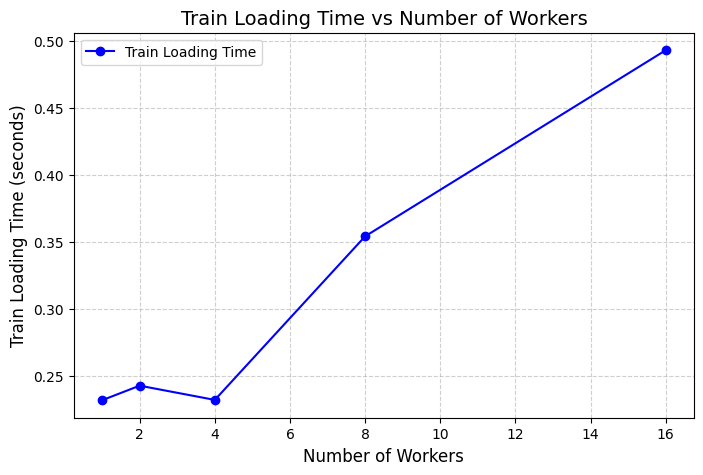

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(number_workers, trainloading, marker='o', linestyle='-', color='b', label='Train Loading Time')

# Add labels, title, and grid
plt.xlabel('Number of Workers', fontsize=12)
plt.ylabel('Train Loading Time (seconds)', fontsize=12)
plt.title('Train Loading Time vs Number of Workers', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Show plot
plt.show()

#### Optimizer

In [19]:
opt = ["sgd","sgd-nest",'adagrad','adadelta',"adam"]
best_nw = 4
train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=128,
    collate_fn=data_collator,
    num_workers = best_nw
)
train_accuracys = []
# optim = torch.optim
for op in opt:
    print(f"\n{op =}" )
    #reset model
    encoder = Encoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
    decoder = Decoder(vocab_size=tokenizer.vocab_size + 1,
                      max_len=512,
                      d_k=16,
                      d_model=64,
                      n_heads=4,
                      n_layers=2,
                      dropout_prob=0.1)
    transformer = Transformer(encoder,decoder)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    encoder.to(device)
    decoder.to(device)
    #set opt
    if op == "sgd":
        optimizer = torch.optim.SGD(transformer.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
    elif op == "sgd-nest":
        optimizer = torch.optim.SGD(transformer.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4, nesterov=True)
    elif op == "adagrad":
        optimizer = torch.optim.Adagrad(transformer.parameters(),lr=0.1)
    elif op == "adadelta":
        optimizer = torch.optim.Adadelta(transformer.parameters(),lr=0.1)
    elif op == "adam":
        optimizer = torch.optim.Adam(transformer.parameters(),lr = 0.1)
        
    train_losses, test_losses,time_epoch,time_dataloading,time_training,train_accuracy,test_accuracy = train(
        transformer, criterion, optimizer, train_loader, valid_loader, epochs=5)

    train_accuracys.append(train_accuracy[-1])

# optimizer = torch.optim.Adam(transformer.parameters())

    
    

    


op ='sgd'
cuda:0
Epoch 1/5, Train Loss: 6.9649, Training Accuracy: 0.2918      Test Loss: 5.6637, Test Accuracy: 0.3682, Epoch Time: 2.9920, Dataloading Time: 0.1976, Training Time: 2.1341
Epoch 2/5, Train Loss: 5.2776, Training Accuracy: 0.3876      Test Loss: 4.9375, Test Accuracy: 0.4198, Epoch Time: 2.9970, Dataloading Time: 0.2064, Training Time: 2.1047
Epoch 3/5, Train Loss: 4.7164, Training Accuracy: 0.4260      Test Loss: 4.5933, Test Accuracy: 0.4457, Epoch Time: 2.9661, Dataloading Time: 0.2200, Training Time: 2.1056
Epoch 4/5, Train Loss: 4.3641, Training Accuracy: 0.4443      Test Loss: 4.3878, Test Accuracy: 0.4575, Epoch Time: 3.0010, Dataloading Time: 0.2068, Training Time: 2.1243
Epoch 5/5, Train Loss: 4.1139, Training Accuracy: 0.4598      Test Loss: 4.2019, Test Accuracy: 0.4715, Epoch Time: 3.1968, Dataloading Time: 0.2141, Training Time: 2.3192

op ='sgd-nest'
cuda:0
Epoch 1/5, Train Loss: 6.7103, Training Accuracy: 0.3251      Test Loss: 5.4308, Test Accuracy: 0.4

In [20]:
train_accuracys

[np.float64(0.45982823457668465),
 np.float64(0.46590100619981706),
 np.float64(0.17758410407561745),
 np.float64(0.3381187112511434),
 np.float64(0.17692346783209675)]

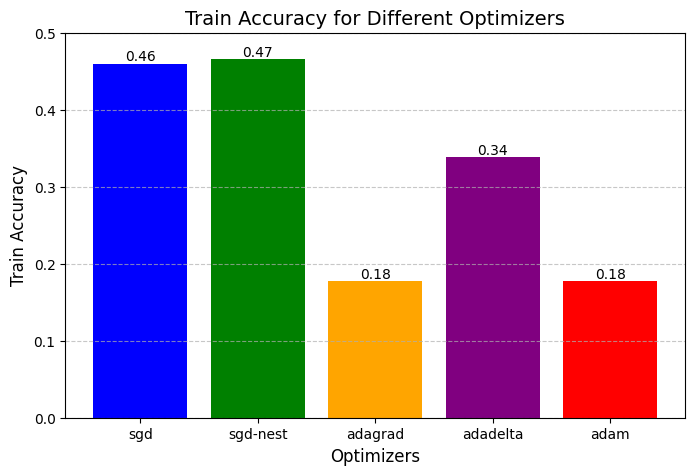

In [21]:

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(opt, train_accuracys, color=['blue', 'green', 'orange', 'purple', 'red'])

# Add labels and title
plt.xlabel('Optimizers', fontsize=12)
plt.ylabel('Train Accuracy', fontsize=12)
plt.title('Train Accuracy for Different Optimizers', fontsize=14)

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

# Show plot
plt.ylim(0, 0.5)  # Adjust the y-axis for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Using sgd-nest for best result

In [22]:
optimizer = torch.optim.SGD(transformer.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4, nesterov=True)


### Exploring Torch.compile (need to rework)

In [74]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torch.utils
import torchvision
import torchvision.transforms as transforms

import os
import argparse
import pandas as pd
import time


In [80]:
mode = [ 'max-autotune']
epoch_times = []
for m in mode:
    # print(f"\n{op =}" )
    #reset model
    encoder = Encoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
    decoder = Decoder(vocab_size=tokenizer.vocab_size + 1,
                      max_len=512,
                      d_k=16,
                      d_model=64,
                      n_heads=4,
                      n_layers=2,
                      dropout_prob=0.1)
    transformer = Transformer(encoder,decoder)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # encoder.to(device)
    # decoder.to(device)
    if m in ["default","reduce-overhead",'max-autotune']:
        # encoder = torch.compile(encoder,mode=m,backend='inductor')
        # decoder = torch.compile(decoder,mode=m,backend='inductor')
        # transformer = torch.compile(transformer,mode=m,backend='inductor')
        transformer = torch.compile(transformer, mode=m, backend='inductor')

        print("Torch compile training---")
    # encoder.to(device)
    # decoder.to(device)
    transformer.to(device)

    transformer= torch.nn.DataParallel(transformer)
    cudnn.benchmark = True

    

    train_losses, test_losses,time_epoch,time_dataloading,time_training,train_accuracy,test_accuracy = train(
        transformer, criterion, optimizer, train_loader, valid_loader, epochs=5)

    epoch_times.append(np.mean(time_epoch))

    




cuda:0
Torch compile training---


TorchRuntimeError: Failed running call_function <built-in function add>(*(FakeTensor(..., device='cuda:0', size=(32, s1, 64),
           grad_fn=<EmbeddingBackward0>), FakeTensor(..., device='cuda:0', size=(1, 512, 64))), **{}):
The size of tensor a (s1) must match the size of tensor b (512) at non-singleton dimension 1)

from user code:
   File "/tmp/ipykernel_1096/1340379155.py", line 8, in forward
    enc_output = self.encoder(enc_input, enc_mask)
  File "/home/wei/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_1096/300891069.py", line 28, in forward
    x = self.pos_encoding(x)
  File "/home/wei/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_1096/1597975147.py", line 16, in forward
    x = x + self.pe[:, :x.size(1), :]

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


# Optimizing Inference Speed

## Flash Attention

In [3]:
!export LD_LIBRARY_PATH=/usr/local/cuda-12/lib64:$LD_LIBRARY_PATH
!export PATH=$PATH:/usr/local/cuda-12/bin


In [4]:
!export CUDA_HOME=/usr/local/cuda-12 && export LD_LIBRARY_PATH=/usr/local/cuda-12/lib64:$LD_LIBRARY_PATH && export PATH=/usr/local/cuda-12/bin:$PATH && nvcc --version && pip install flash-attn

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:18:05_PDT_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0
Defaulting to user installation because normal site-packages is not writeable
  Using cached flash_attn-2.7.0.post2.tar.gz (2.7 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 KB 772.8 kB/s eta 0:00:00MB/s eta 0:00:01
  Created wheel for flash-attn: filename=flash_attn-2.7.0.post2-cp310-cp310-linux_x86_64.whl size=183278540 sha256=eb4eb73682931a7c591a97ff12926b392ebea4c67e8d9846537925fbfcddaecf
  Stored in directory: /home/wei/.cache/pip/wheels/bf/e3/ed/5e845387d52f2debd1bafb847bf3d774d3f0a3c8e31b1dc948
Successfully built flash-attn


In [5]:
!pip install nvidia-pyindex
!pip install nvidia-cuda-nvcc


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8416 sha256=80b2ed94eaa6f8f9fe09041a7d0bbb6cb5dd9f257abe34e5fd8233a7f8d2dfcf
  Stored in directory: /home/wei/.cache/pip/wheels/2c/af/d0/7a12f82cab69f65d51107f48bcd6179e29b9a69a90546332b3
Successfully built nvidia-pyindex
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: The HTML index page being used (https://developer.download.nvidia.com/compute/redist/nvidia-cuda-nvcc/) is not a proper HTML 5 document. This is in violation of PEP 503 which requires these pages to be well-formed HTML 5 documents. Please reach out to the owners of this index page, and ask them to update this index page to a valid HTML 5 document. pip 22.2 will enforce this behaviour change. Discussion c

In [7]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


In [6]:
# !pip install flash-attn


In [11]:
# !pytorch --version
import flash_attn

In [9]:
from models.Transformer_flash_attention import Encoder,Decoder,Transformer_flash_attention

ImportError: cannot import name 'flash_attn_unpadded_func' from 'flash_attn.flash_attn_interface' (/home/wei/.local/lib/python3.10/site-packages/flash_attn/flash_attn_interface.py)

In [23]:
# !head data/cnn_dailymail/train.csv
import pandas as pd
df = pd.read_csv('data/cnn_dailymail/train.csv', sep=",", header=None)
df_test = pd.read_csv('data/cnn_dailymail/test.csv', sep=",", header=None)
df = df.iloc[:10000]
df_test = df_test.iloc[:1000]

df.to_csv('data/cnn_dailymail/train_short.csv', index=None)
df_test.to_csv('data/cnn_dailymail/test_short.csv', index=None)

df.head()

,0,1,2
0,id,article,highlights
1,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
2,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
3,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
4,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...


In [24]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")


In [25]:
maxinput_len = df[1].str.len().max()
maxoutput_len = df[2].str.len().max()
maxinput_tokens = df[df[1].str.len() == maxinput_len][1].apply(lambda x: len(tokenizer.tokenize(x)))
maxoutput_tokens = df[df[2].str.len() == maxoutput_len][2].apply(lambda x: len(tokenizer.tokenize(x)))
maxinput_tokens=maxinput_tokens.max()
maxoutput_tokens = maxoutput_tokens.max()
print("Max token in col1:", maxinput_tokens)
print("Max token in col2:", maxoutput_tokens)


Token indices sequence length is longer than the specified maximum sequence length for this model (3521 > 512). Running this sequence through the model will result in indexing errors


Max token in col1: 3521
Max token in col2: 926


In [26]:
# maxinput_tokens = df[1].apply(lambda x: len(tokenizer.tokenize(x)))
# maxoutput_tokens = df[2].apply(lambda x: len(tokenizer.tokenize(x)))
# maxinput_tokens=maxinput_tokens.max()
# maxoutput_tokens=maxoutput_tokens.max()
# print(f"{maxinput_tokens=}")
# print(f"{maxoutput_tokens=}")

In [27]:
# # removing the id fiels
# df.column =["article", "highlights"]
# df.to_csv("/data/cnn_dailymail"
# print(f"{df.shape = }")


In [28]:
!pip install transformers datasets sentencepiece sacremoses


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [29]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
maxinput_tokens = 3521
maxoutput_tokens = 926


In [30]:
from datasets import load_dataset
train_dataset = load_dataset('csv', data_files='data/cnn_dailymail/train_short.csv')
test_dataset = load_dataset('csv', data_files='data/cnn_dailymail/test_short.csv')
train_dataset = train_dataset.remove_columns("0")
test_dataset = test_dataset.remove_columns("0")




Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [31]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['1', '2'],
        num_rows: 10000
    })
})

In [32]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['1', '2'],
        num_rows: 1000
    })
})

In [33]:
# from transformers import AutoTokenizer
# checkpoint = 'distilbert-base-cased'
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [34]:
article1 = train_dataset["train"][1]["1"]
article1

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [35]:
highlights1 = train_dataset["train"][1]["2"]
highlights1

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [36]:
targets = tokenizer(text_target=highlights1)
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['[CLS]',
 'Bishop',
 'John',
 'F',
 '##old',
 '##a',
 ',',
 'of',
 'North',
 'Dakota',
 ',',
 'is',
 'taking',
 'time',
 'off',
 'after',
 'being',
 'diagnosed',
 '.',
 'He',
 'contracted',
 'the',
 'infection',
 'through',
 'contaminated',
 'food',
 'in',
 'Italy',
 '.',
 'Church',
 'members',
 'in',
 'Fargo',
 ',',
 'Grand',
 'Fork',
 '##s',
 'and',
 'James',
 '##town',
 'could',
 'have',
 'been',
 'exposed',
 '.',
 '[SEP]']

In [37]:
max_input_length = maxinput_tokens
max_target_length = maxoutput_tokens

def preprocess_function(batch):
    model_inputs = tokenizer(
        batch['1'], max_length=max_input_length, truncation=True)

    # Set up the tokenizer for targets
    labels = tokenizer(
        text_target=batch['2'], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [38]:
tokenized_datasets = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset["train"].column_names,
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [39]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

In [40]:
tokenized_datasets_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_dataset["train"].column_names,
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [41]:
tokenized_datasets_test

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [42]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer)


In [43]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0, 5)])
batch.keys()


dict_keys(['input_ids', 'attention_mask', 'labels'])

In [44]:
batch['input_ids']


tensor([[  101,  3342,   102,  ...,     0,     0,     0],
        [  101,  1650,   119,  ...,     0,     0,     0],
        [  101,   113, 13597,  ...,     0,     0,     0],
        [  101,   138,  6882,  ...,  2774,   119,   102],
        [  101,   113, 13597,  ...,     0,     0,     0]])

In [45]:
batch['attention_mask']


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])

In [46]:
batch['labels']


tensor([[  101, 12976,   102,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100],
        [  101,  3167,  1287,   143, 11015,  1161,   117,  1104,  1456,  7241,
           117,  1110,  1781,  1159,  1228,  1170,  1217, 11534,   119,  1124,
         11058,  1103,  8974,  1194, 21636,  2094,  1107,  2413,   119,  1722,


In [47]:
tokenizer.all_special_ids


[100, 102, 0, 101, 103]

In [48]:
tokenizer.all_special_tokens


['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [49]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)
valid_loader = DataLoader(
    tokenized_datasets_test["train"],
    batch_size=32,
    collate_fn=data_collator
)


In [50]:
# check how it works
for batch in train_loader:
  for k, v in batch.items():
    print("k:", k, "v.shape:", v.shape)
  break

k: input_ids v.shape: torch.Size([32, 2174])
k: attention_mask v.shape: torch.Size([32, 2174])
k: labels v.shape: torch.Size([32, 126])


In [51]:
tokenizer.vocab_size


28996

In [52]:
tokenizer.decode([2899])


'championship'

# Model

In [53]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt

In [54]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, causal=False):
    super().__init__()

    # Assume d_v = d_k
    self.d_k = d_k
    self.n_heads = n_heads

    self.key = nn.Linear(d_model, d_k * n_heads)
    self.query = nn.Linear(d_model, d_k * n_heads)
    self.value = nn.Linear(d_model, d_k * n_heads)

    # final linear layer
    self.fc = nn.Linear(d_k * n_heads, d_model)

    # causal mask
    # make it so that diagonal is 0 too
    # this way we don't have to shift the inputs to make targets
    self.causal = causal
    if causal:
      cm = torch.tril(torch.ones(max_len, max_len))
      self.register_buffer(
          "causal_mask",
          cm.view(1, 1, max_len, max_len)
      )

  def forward(self, q, k, v, pad_mask=None):
    q = self.query(q) # N x T x (hd_k)
    k = self.key(k)   # N x T x (hd_k)
    v = self.value(v) # N x T x (hd_v)

    N = q.shape[0]
    T_output = q.shape[1]
    T_input = k.shape[1]

    # change the shape to:
    # (N, T, h, d_k) -> (N, h, T, d_k)
    # in order for matrix multiply to work properly
    q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
    k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
    v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)

    # compute attention weights
    # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
    attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    if pad_mask is not None:
      attn_scores = attn_scores.masked_fill(
          pad_mask[:, None, None, :] == 0, float('-inf'))
    if self.causal:
      attn_scores = attn_scores.masked_fill(
          self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf'))
    attn_weights = F.softmax(attn_scores, dim=-1)
    
    # compute attention-weighted values
    # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
    A = attn_weights @ v

    # reshape it back before final linear layer
    A = A.transpose(1, 2) # (N, T, h, d_k)
    A = A.contiguous().view(N, T_output, self.d_k * self.n_heads) # (N, T, h*d_k)

    # projection
    return self.fc(A)

In [55]:
class EncoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    self.dropout = nn.Dropout(p=dropout_prob)
  
  def forward(self, x, pad_mask=None):
    x = self.ln1(x + self.mha(x, x, x, pad_mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)
    return x


In [56]:
class DecoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.ln3 = nn.LayerNorm(d_model)
    self.mha1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
    self.mha2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    self.dropout = nn.Dropout(p=dropout_prob)
  
  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    # self-attention on decoder input
    x = self.ln1(
        dec_input + self.mha1(dec_input, dec_input, dec_input, dec_mask))

    # multi-head attention including encoder output
    x = self.ln2(x + self.mha2(x, enc_output, enc_output, enc_mask))

    x = self.ln3(x + self.ann(x))
    x = self.dropout(x)
    return x


In [57]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x):
    # x.shape: N x T x D
    x = x + self.pe[:, :x.size(1), :]
    return self.dropout(x)


In [58]:
class Encoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
              #  n_classes,
               dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [
        EncoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    # self.fc = nn.Linear(d_model, n_classes)
  
  def forward(self, x, pad_mask=None):
    x = self.embedding(x)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, pad_mask)

    # many-to-one (x has the shape N x T x D)
    # x = x[:, 0, :]

    x = self.ln(x)
    # x = self.fc(x)
    return x


In [59]:
class Decoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
               dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [
        DecoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, vocab_size)
  
  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    x = self.embedding(dec_input)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(enc_output, x, enc_mask, dec_mask)
    x = self.ln(x)
    x = self.fc(x) # many-to-many
    return x


In [60]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
  
  def forward(self, enc_input, dec_input, enc_mask, dec_mask):
    enc_output = self.encoder(enc_input, enc_mask)
    dec_output = self.decoder(enc_output, dec_input, enc_mask, dec_mask)
    return dec_output


### Training

In [61]:
# test it
encoder = Encoder(vocab_size=tokenizer.vocab_size,
                  max_len=maxinput_tokens,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=tokenizer.vocab_size,
                  max_len=maxoutput_tokens,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
transformer = Transformer(encoder, decoder)

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cuda:0


Decoder(
  (embedding): Embedding(28996, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
 

In [63]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters())


In [64]:
from datetime import datetime
# A function to encapsulate the training loop
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for batch in train_loader:
      # move data to GPU (enc_input, enc_mask, translation)
      batch = {k: v.to(device) for k, v in batch.items()}

      # zero the parameter gradients
      optimizer.zero_grad()

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      # shift targets forwards to get decoder_input
      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:, 0] = 101

      # also convert all -100 to pad token id
      dec_input = dec_input.masked_fill(
          dec_input == -100, tokenizer.pad_token_id)

      # make decoder input mask
      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

      # Forward pass
      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2, 1), targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for batch in valid_loader:
      batch = {k: v.to(device) for k, v in batch.items()}

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      # shift targets forwards to get decoder_input
      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:, 0] = 101

      # change -100s to regular padding
      dec_input = dec_input.masked_fill(
          dec_input == -100, tokenizer.pad_token_id)

      # make decoder input mask
      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2, 1), targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [65]:
train_losses, test_losses = train(
    transformer, criterion, optimizer, train_loader, valid_loader, epochs=15)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.94 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 8.66 GiB is allocated by PyTorch, and 3.26 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
xe = np.random.randint(0, 20_000, size=(8, 512))
xe_t = torch.tensor(xe).to(device)

xd = np.random.randint(0, 10_000, size=(8, 256))
xd_t = torch.tensor(xd).to(device)

maske = np.ones((8, 512))
maske[:, 256:] = 0
maske_t = torch.tensor(maske).to(device)

maskd = np.ones((8, 256))
maskd[:, 128:] = 0
maskd_t = torch.tensor(maskd).to(device)

out = transformer(xe_t, xd_t, maske_t, maskd_t)
out.shape

In [ ]:
out


In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt


In [ ]:
!head spa.txt


In [ ]:
import pandas as pd
df = pd.read_csv('spa.txt', sep="\t", header=None)
df.head()

In [ ]:
df.shape


In [ ]:
df = df.iloc[:30_000] # takes too long


In [ ]:
df.columns = ['en', 'es']
df.to_csv('spa.csv', index=None)

In [ ]:
!head spa.csv


In [ ]:
!pip install transformers datasets sentencepiece sacremoses


In [ ]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='spa.csv')

In [ ]:
raw_dataset


In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [ ]:
en_sentence = split["train"][0]["en"]
es_sentence = split["train"][0]["es"]

inputs = tokenizer(en_sentence)
targets = tokenizer(text_target=es_sentence)

tokenizer.convert_ids_to_tokens(targets['input_ids'])


In [ ]:
es_sentence


In [ ]:
max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
    model_inputs = tokenizer(
        batch['en'], max_length=max_input_length, truncation=True)

    # Set up the tokenizer for targets
    labels = tokenizer(
        text_target=batch['es'], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [ ]:
tokenized_datasets = split.map(
    preprocess_function,
    batched=True,
    remove_columns=split["train"].column_names,
)


In [ ]:
tokenized_datasets


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer)


In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0, 5)])
batch.keys()


In [ ]:
batch['input_ids']


In [ ]:
batch['attention_mask']


In [ ]:
batch['labels']


In [ ]:
tokenizer.all_special_ids


In [ ]:
tokenizer.all_special_tokens


In [ ]:
tokenizer('<pad>')


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)
valid_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=32,
    collate_fn=data_collator
)


In [ ]:
https://deeplearningcourses.com/notebooks/YROaDO6P4h3GNPYKYNlWjA/mHntSDrJRP9_eMCl7KMl6w